In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
np.random.seed(10)

import tensorflow as tf
# tf.set_random_seed(10)

import tensorflow.keras as keras
import tensorflow_probability as tfp
tfd = tfp.distributions

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K

# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

train_mode = False

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import re
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import pyplot as plt


mpl.rcParams['ps.useafm'] = True
#mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True
mpl.rc('text', usetex=True) 
mpl.rcParams['text.latex.unicode']=True
# mpl.use( "cairo", warn=False, force=True)
print(mpl.pyplot.get_backend())

mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage[T1]{fontenc}',
       r'\usepackage[default]{gillius}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  


def init_plotting():
    plt.rcParams['figure.figsize'] = (8, 5)
    plt.rcParams['font.size'] = 20
    print(plt.rcParams['font.family'] )
    plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['axes.titlesize'] = plt.rcParams['font.size']
    plt.rcParams['legend.fontsize'] = 0.9*plt.rcParams['font.size']
    plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
#    print(plt.rcParams['savefig.dpi'])
#    plt.rcParams['savefig.dpi'] = 2*plt.rcParams['savefig.dpi']
    plt.rcParams['xtick.minor.visible']=False
    plt.rcParams['ytick.minor.visible']=False
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.minor.size'] = 3
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['xtick.minor.width'] = 2
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.minor.size'] = 3
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['ytick.minor.width'] = 2
    plt.rcParams['ytick.color'] = "black"#"#808080"
    plt.rcParams['xtick.color'] = "black"#"#808080"
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    #ax.tick_params(direction='out', length=6, width=2, colors='r',
    #           grid_color='r', grid_alpha=0.5)
    plt.rcParams['legend.frameon'] = False
    plt.rcParams['legend.loc'] = 'best'
    plt.rcParams['axes.linewidth'] = 2

init_plotting()



def hide_spines():
    """Hides the top and rightmost axis spines from view for all active
    figures and their respective axes."""
    # Retrieve a list of all current figures.
    figures = [x for x in mpl._pylab_helpers.Gcf.get_all_fig_managers()]
    for figure in figures:
        # Get all Axis instances related to the figure.
        for ax in figure.canvas.figure.get_axes():
            
            ax.spines['left'].set_color("#808080")
            ax.spines['bottom'].set_color("#808080")
            ax.spines['right'].set_color("#808080")
            ax.spines['top'].set_color("#808080")
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
    
            ax.spines['top'].set_linewidth(0.1)
            ax.spines['top'].set_linestyle(':')
            ax.spines['right'].set_linewidth(0.1)
            ax.spines['right'].set_linestyle(':')


# hide_spines()

module://ipykernel.pylab.backend_inline
['sans-serif']


/home/rmlans/anaconda3/envs/deephyper_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  from ipykernel import kernelapp as app


In [3]:
def ReadData(path_program = './'):
    
    fileIn = path_program + 'pca_inputs.npy'
    TrainfilesAll = np.load(fileIn)

    fileInZ = path_program + 'pca_targets.npy'
    TrainZAll = np.load(fileInZ)


    TrainshuffleOrder = np.arange(TrainfilesAll.shape[0])
    np.random.shuffle(TrainshuffleOrder)

    Trainfiles = TrainfilesAll[TrainshuffleOrder]
    TrainZ = TrainZAll[TrainshuffleOrder]

    X_train = Trainfiles[:num_train]  # color mag
    X_test = Trainfiles[num_train :]  # color mag

    y_train = TrainZ[:num_train]  # spec z
    y_test = TrainZ[num_train :] # spec z

    return X_train, y_train, X_test, y_test#, ymax, ymin, xmax, xmin

In [4]:
num_components = 1
input_shape = 2
output_shape = [400]

n_epochs = 5000
learning_rate = 1e-3
decay_rate = 0.0
num_train = 90
num_test = 10

In [5]:
X_train, y_train, X_test, y_test = ReadData()

# Add varying white noisy counterparts
y_train_noise = np.copy(y_train)
y_test_noise = np.copy(y_test)
for snap in range(10):
    y_noise = np.random.normal(loc=0.0,scale=np.random.uniform(low=0.0,high=2.0),size=(90,40))
    y_train_noise[:,snap*40:(snap+1)*40] = y_train[:,snap*40:(snap+1)*40] + y_noise

    y_noise = np.random.normal(loc=0.0,scale=np.random.uniform(low=0.0,high=2.0),size=(10,40))
    y_test_noise[:,snap*40:(snap+1)*40] = y_test[:,snap*40:(snap+1)*40] + y_noise

preproc_2 = Pipeline([('minmaxscaler', MinMaxScaler())])
y_train = preproc_2.fit_transform(y_train)
y_test = preproc_2.transform(y_test)

print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in training data: (90, 2)
Size of output in training data: (90, 400)
Size of features in test data: (10, 2)
Size of output in test data: (10, 400)


In [6]:
weights_filepath = 'mdn_model.h5'

model = keras.Sequential([
    keras.layers.Dense(units=8, activation='relu', input_shape=(input_shape,)),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=512, activation='relu'),
    keras.layers.Dense(tfp.layers.MixtureNormal.params_size(num_components, output_shape)),
    tfp.layers.MixtureNormal(num_components, output_shape)
    ])

def negloglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)


callback = tf.keras.callbacks.LearningRateScheduler(lambda e: 0.001 if e < 5 else 0.0001)
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint,callback,earlystopping]


opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1= decay_rate, amsgrad = True)
model.compile(loss=negloglik, optimizer=opt, metrics=[])

W0506 16:13:30.372069 139916491847488 deprecation.py:323] From /home/rmlans/anaconda3/envs/deephyper_env/lib/python3.6/site-packages/tensorflow_probability/python/internal/distribution_util.py:493: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
if train_mode:
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=4, callbacks=callbacks_list, verbose=1, validation_split=0.1)
    ## Plotting loss function
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'],label='training')
    plt.legend()
    plt.xlabel('Epochs', fontsize = 28)
    plt.ylabel('Loss', fontsize = 28)

In [8]:
model.load_weights(weights_filepath)

In [9]:
import time
start = time.time()

y_pred = model(X_test)
y_pred_mean = y_pred.components_distribution.mean() 
y_pred_variance = y_pred.components_distribution.variance() 
y_pred_std = np.sqrt(y_pred_variance)

end = time.time()

W0506 16:13:58.914758 139916491847488 base_layer.py:1819] Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [10]:
print('Time taken on average for MDN prediction:',(end-start)/num_test)

Time taken on average for MDN prediction: 0.01664297580718994


In [11]:
# Rescale
y_pred_mean = preproc_2.inverse_transform(y_pred_mean[:,0,:])
y_pred_std = preproc_2.inverse_transform(y_pred_std[:,0,:])
y_pred_mean = np.expand_dims(y_pred_mean,axis=1)
y_pred_std = np.expand_dims(y_pred_std,axis=1)
y_test = preproc_2.inverse_transform(y_test)

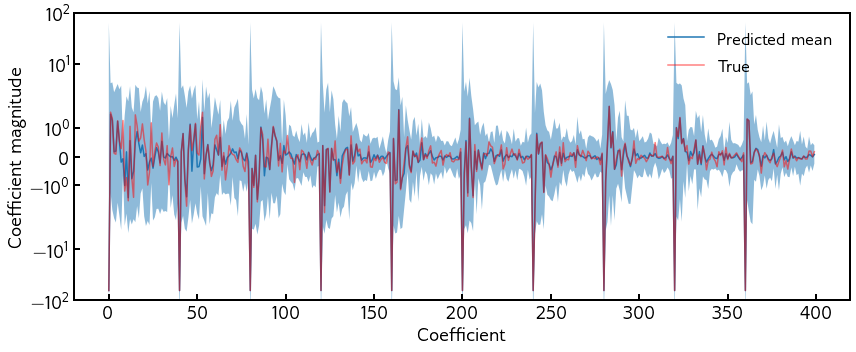

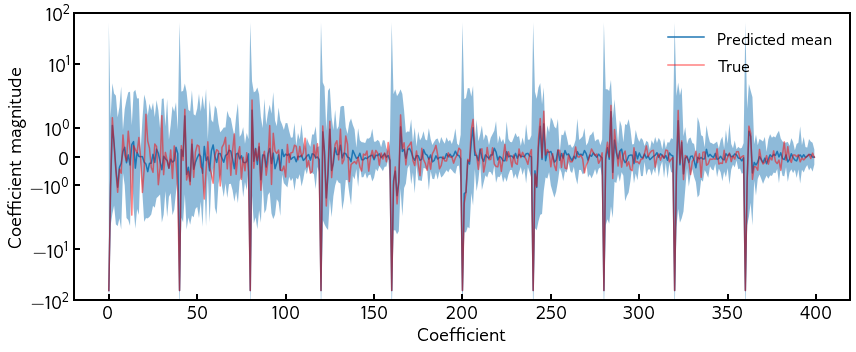

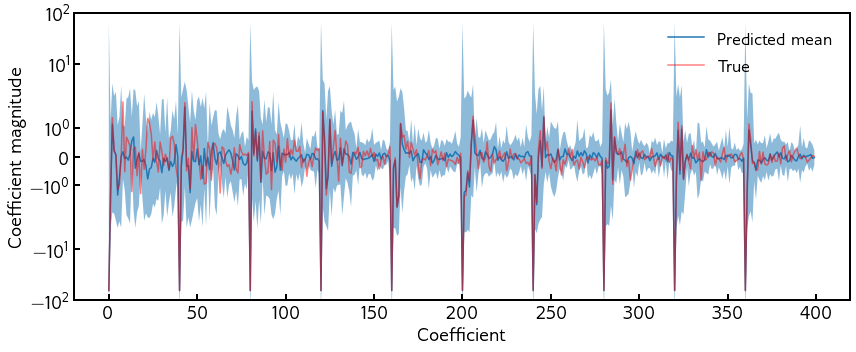

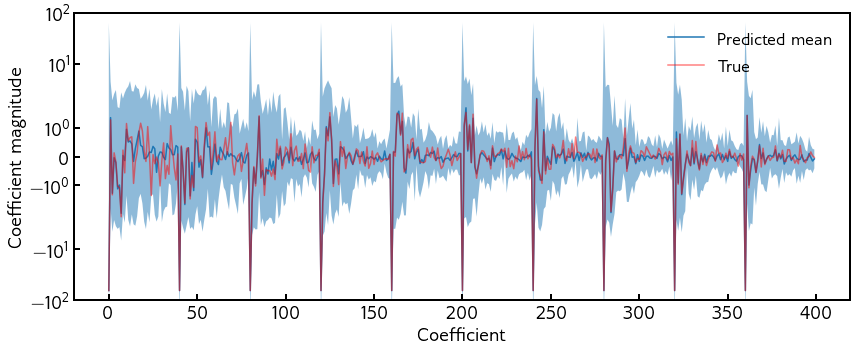

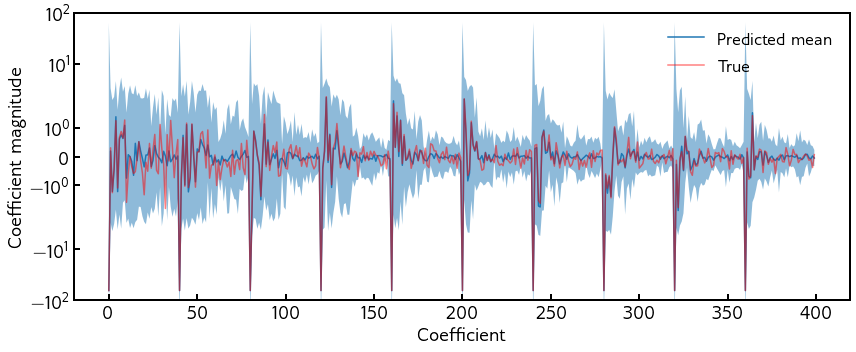

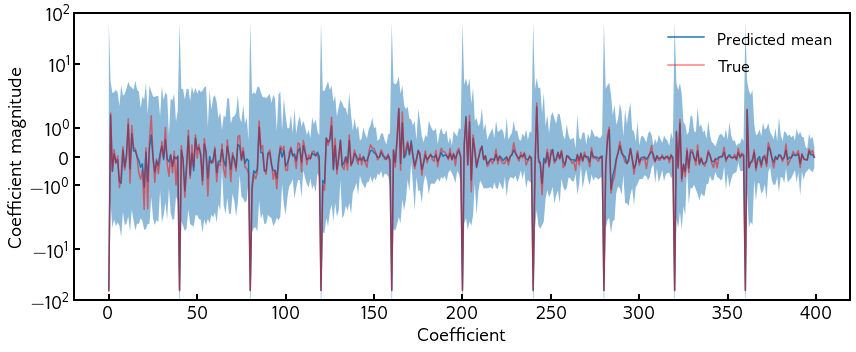

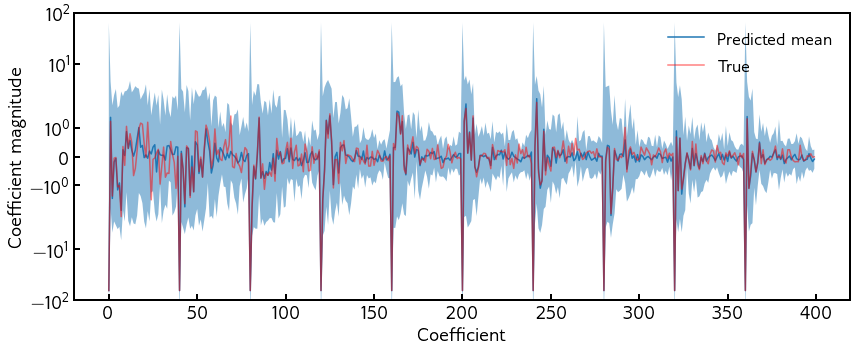

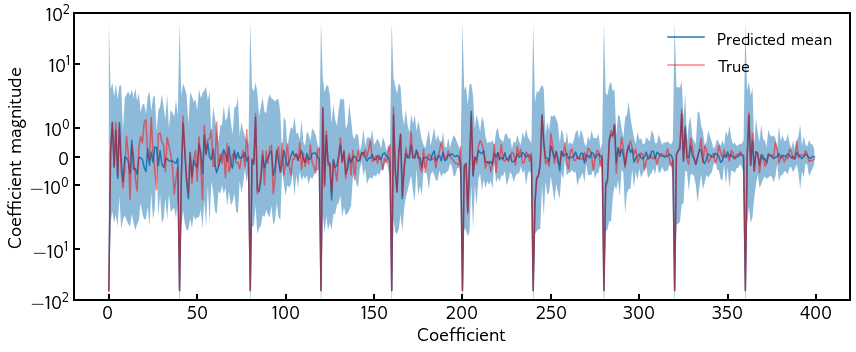

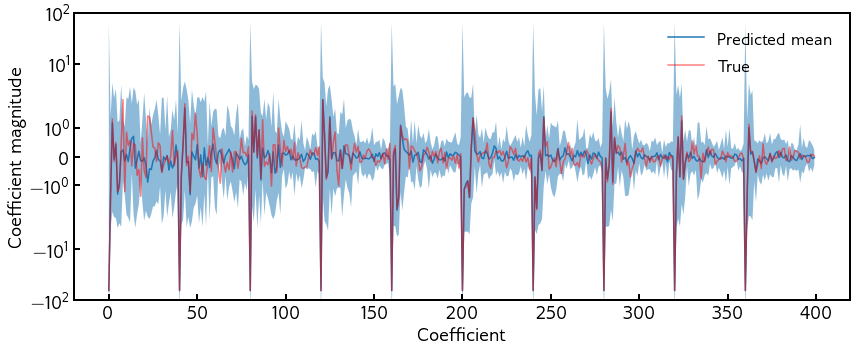

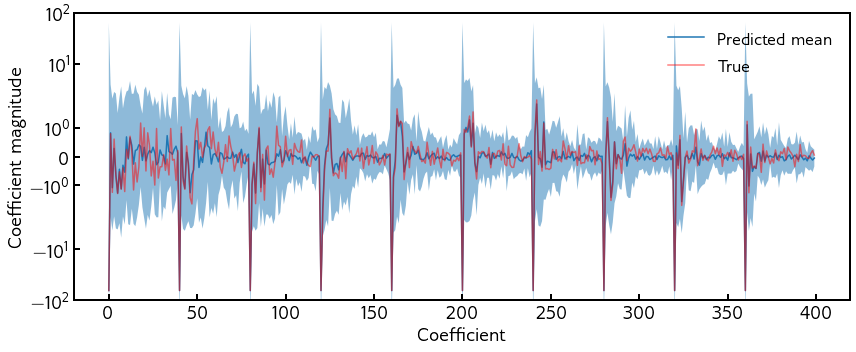

In [12]:
### Closer look near 0. error bars at 2 sigma
x = np.arange(400)
for test_num in range(10):
    plt.figure(figsize=(12,5))
    plt.plot(x, y_pred_mean[test_num, 0, :],label='Predicted mean')
    plt.fill_between(x, y_pred_mean[test_num, 0, :] - 2*y_pred_std[test_num, 0, :], y_pred_mean[test_num, 0, :] + 2*y_pred_std[test_num, 0, :], alpha = 0.5)
    plt.plot(x, y_test[test_num], 'r', alpha = 0.5, label='True')
    plt.yscale('symlog')
    plt.ylabel('Coefficient magnitude')
    plt.xlabel('Coefficient')
    plt.ylim((-100,100))
    plt.legend(loc='upper right')
    plt.tight_layout()
#     plt.savefig('MDN_Coefficient_'+str(test_num)+'_.png')
    plt.show()

In [14]:
# Load PCA vectors and truncate to right dimension
pca_vectors = np.load('PCA_Vectors.npy')
pca_vectors = pca_vectors[:,:40]

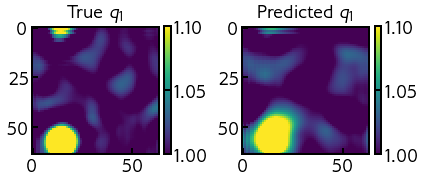

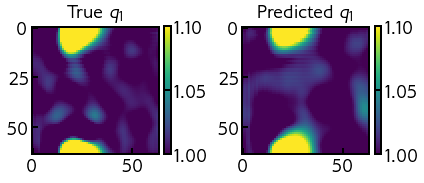

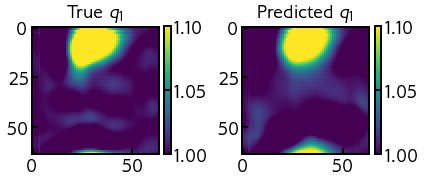

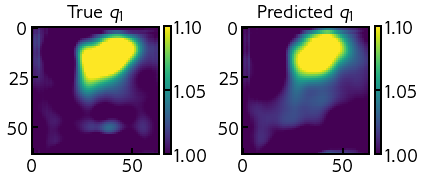

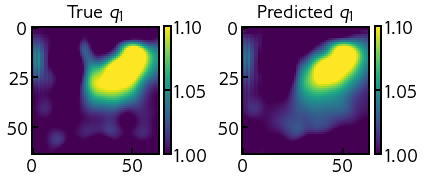

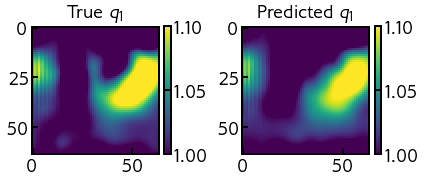

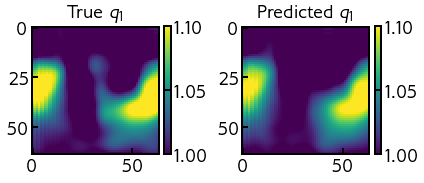

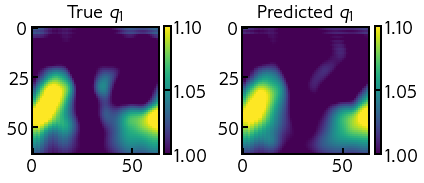

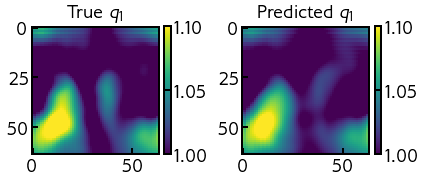

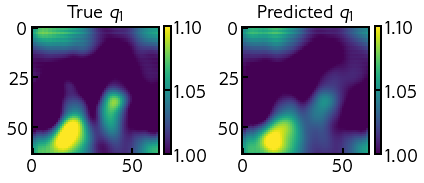

In [15]:
# Do visualization of fields for one simulation
test_sim = 0
for time in range(10):
    true_field = np.matmul(pca_vectors,np.transpose(y_test[test_sim,40*time:40*(time+1)]))
    true_field = true_field.reshape(64,64)
    
    pred_field = np.matmul(pca_vectors,np.transpose(y_pred_mean[test_sim,0,40*time:40*(time+1)]))
    pred_field = pred_field.reshape(64,64)
      
    fig,ax = plt.subplots(nrows=1,ncols=2)
    cx = ax[0].imshow(true_field,vmin=1.0,vmax=1.1)
    ax[0].set_title('True $q_1$')
    ax[1].imshow(pred_field,vmin=1.0,vmax=1.1)
    ax[1].set_title('Predicted $q_1$')
    
    fig.colorbar(cx, ax = ax[0],fraction=0.046, pad=0.04)
    fig.colorbar(cx, ax = ax[1],fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [16]:
# Print PCA error
test_num = 0
for snapshot in range(10):
    print('Test PCA error:',np.mean((y_test[test_num,40*snapshot:40*(snapshot+1)]-y_pred[test_num,40*snapshot:40*(snapshot+1)])**2))

Test PCA error: 106.18553
Test PCA error: 105.639694
Test PCA error: 107.19997
Test PCA error: 106.49243
Test PCA error: 106.591835
Test PCA error: 106.892456
Test PCA error: 106.82495
Test PCA error: 106.35746
Test PCA error: 106.280846
Test PCA error: 106.39213


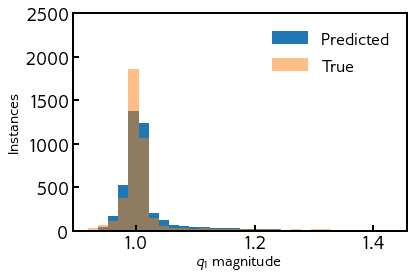

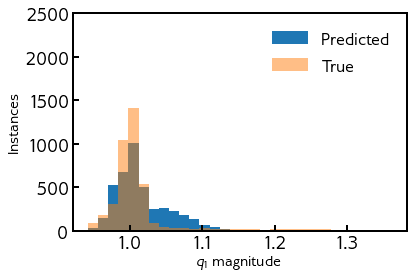

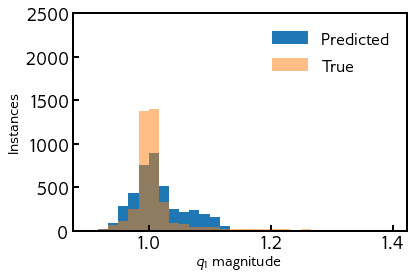

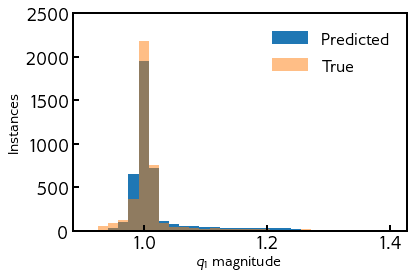

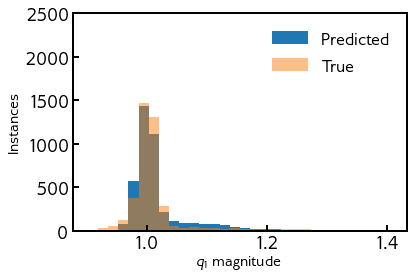

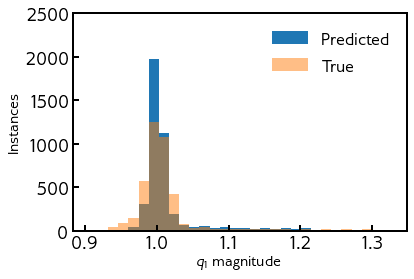

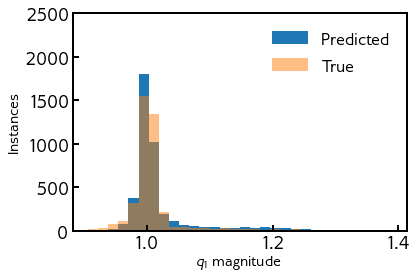

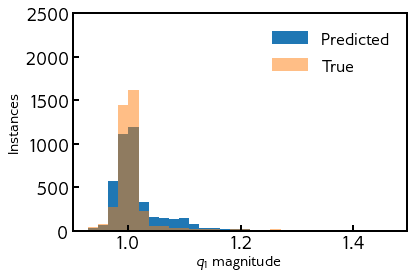

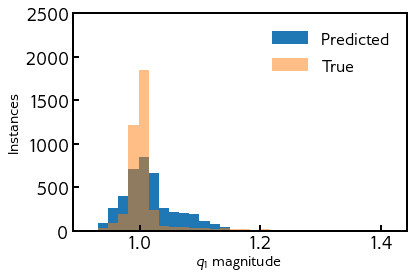

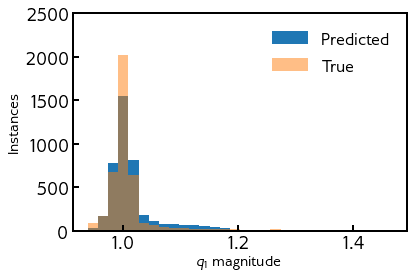

In [17]:
# Do visualization of field PDFs
import matplotlib.ticker as mtick
time = 1
for test_sim in range(10):
    true_field = np.matmul(pca_vectors,np.transpose(y_test[test_sim,40*time:40*(time+1)]))
    pred_field = np.matmul(pca_vectors,np.transpose(y_pred_mean[test_sim,0,40*time:40*(time+1)]))
    
    # Plot of the histogram if truth and predictions
    r_min = true_field.flatten().min()
    r_max = true_field.flatten().max()

    # print(r_min,r_max)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(pred_field.flatten(),range=(r_min,r_max),bins=30,label='Predicted')
    ax.hist(true_field.flatten(),range=(r_min,r_max),bins=30,label='True',alpha=0.5)
    ax.set_xlabel(r'$q_1$ magnitude',fontsize=16)
    ax.set_ylabel(r'Instances',fontsize=16)
    ax.set_ylim((0,2500))
    plt.legend()
    plt.show()

In [18]:
import pandas as pd
from scipy import stats 

def KLD(field1, field2):
    s1 = pd.Series(field1.flatten()).add_prefix('True')
    s2 = pd.Series(field2.flatten()).add_prefix('Predicted')
    
    kde1 = stats.gaussian_kde(s1)
    kde2 = stats.gaussian_kde(s2)

    X = np.arange(s1.min(), s1.max(), 0.01)
    kde1 = kde1(X)
    kde2 = kde2(X)

    plotTrue = False
    if plotTrue:
        plt.figure(323)
        plt.plot(X, kde1)
        plt.plot(X, kde2)

    return kl_divergence(kde1, kde2)


def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [19]:
# Calculate KL-divergence between true and predicted fields
kld_array = np.zeros(shape=(10,10))
for time in range(10):
    for test_num in range(10):
        true_field = np.matmul(pca_vectors,np.transpose(y_test[test_num,40*time:40*(time+1)]))
        pred_field = np.matmul(pca_vectors,np.transpose(y_pred_mean[test_num,0,40*time:40*(time+1)]))
        kld = KLD(pred_field, true_field)
        kld_array[test_num,time] = kld

In [18]:
np.savetxt('KLD.csv',kld_array,delimiter=',',fmt='%1.3f')

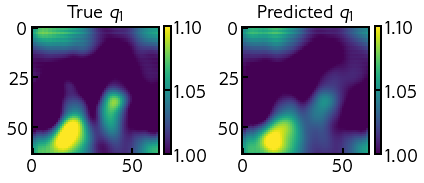

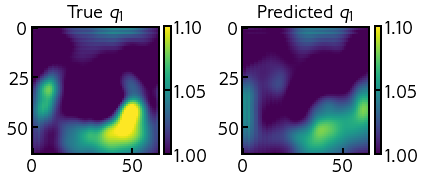

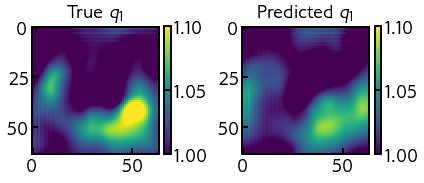

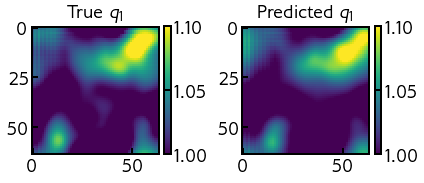

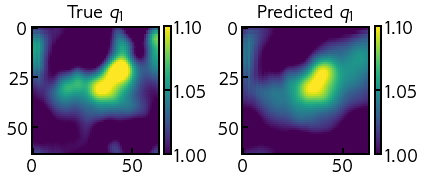

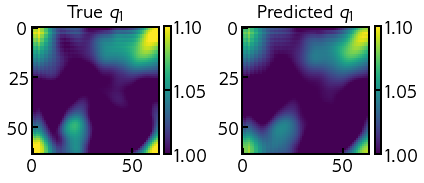

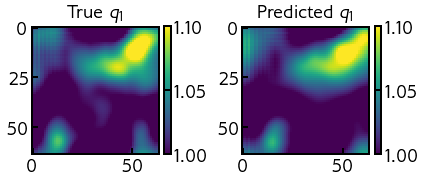

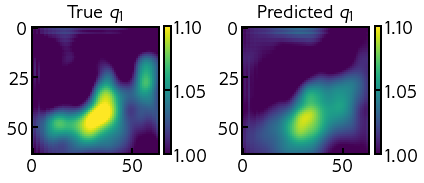

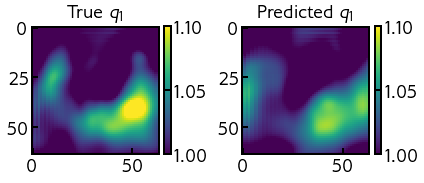

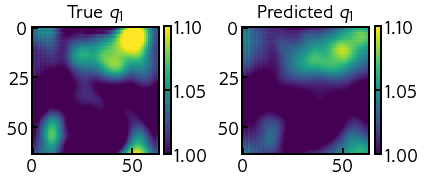

In [20]:
# Do visualization of final time contours for different simulations
time = 9
for test_sim in range(10):
    true_field = np.matmul(pca_vectors,np.transpose(y_test[test_sim,40*time:40*(time+1)]))
    true_field = true_field.reshape(64,64)
    
    pred_field = np.matmul(pca_vectors,np.transpose(y_pred_mean[test_sim,0,40*time:40*(time+1)]))
    pred_field = pred_field.reshape(64,64)
      
    fig,ax = plt.subplots(nrows=1,ncols=2)
    cx = ax[0].imshow(true_field,vmin=1.0,vmax=1.1)
    ax[0].set_title('True $q_1$')
    ax[1].imshow(pred_field,vmin=1.0,vmax=1.1)
    ax[1].set_title('Predicted $q_1$')
    
    fig.colorbar(cx, ax = ax[0],fraction=0.046, pad=0.04)
    fig.colorbar(cx, ax = ax[1],fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()